--- Libraries installed successfully ---

--- Downloading street network for Vellore, Tamil Nadu, India ---
--- Fetching elevation data from Open Topo Data API in batches ---
Processed batch 1/219...
Processed batch 2/219...
Processed batch 3/219...
Processed batch 4/219...
Processed batch 5/219...
Processed batch 6/219...
Processed batch 7/219...
Processed batch 8/219...
Processed batch 9/219...
Processed batch 10/219...
Processed batch 11/219...
Processed batch 12/219...
Processed batch 13/219...
Processed batch 14/219...
Processed batch 15/219...
Processed batch 16/219...
Processed batch 17/219...
Processed batch 18/219...
Processed batch 19/219...
Processed batch 20/219...
Processed batch 21/219...
Processed batch 22/219...
Processed batch 23/219...
Processed batch 24/219...
Processed batch 25/219...
Processed batch 26/219...
Processed batch 27/219...
Processed batch 28/219...
Processed batch 29/219...
Processed batch 30/219...
Processed batch 31/219...
Processed batch 32/219...
Pr

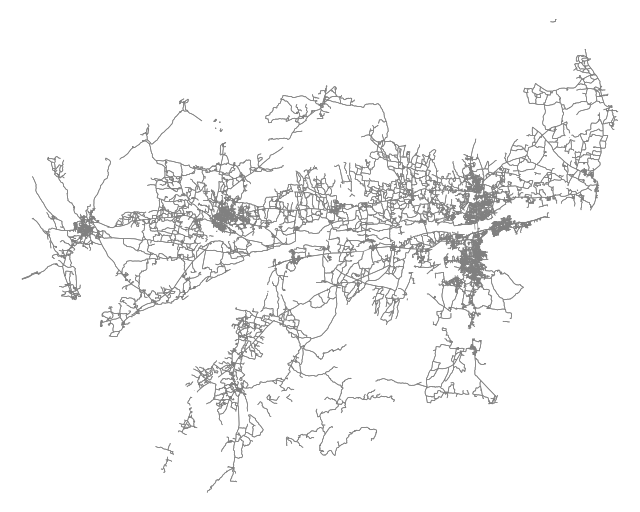

In [10]:
# --- 1. Install necessary libraries ---
# osmnx: to get map data from OpenStreetMap
# folium: to create interactive maps
!pip install osmnx folium -q

import osmnx as ox
import networkx as nx
import requests
import pandas as pd
import time

print("--- Libraries installed successfully ---")

# --- 2. Download the Street Network for Vellore ---
place_name = "Vellore, Tamil Nadu, India"
print(f"\n--- Downloading street network for {place_name} ---")

try:
    # Download the base street network graph
    G = ox.graph_from_place(place_name, network_type='drive', retain_all=False)

    # --- 3. Manually Fetch Elevation Data in Batches---
    print("--- Fetching elevation data from Open Topo Data API in batches ---")

    nodes_df = ox.graph_to_gdfs(G, edges=False)[['y', 'x']]
    elevations = {}
    batch_size = 100 # Number of nodes per API request

    # Loop through the nodes in batches
    for i in range(0, len(nodes_df), batch_size):
        batch_nodes = nodes_df.iloc[i:i+batch_size]
        locations_str = "|".join([f"{lat},{lon}" for lat, lon in batch_nodes[['y', 'x']].values])

        url = f"https://api.opentopodata.org/v1/mapzen?locations={locations_str}"

        try:
            response = requests.get(url)
            if response.status_code == 200:
                results = response.json()['results']
                for j, data in enumerate(results):
                    node_id = batch_nodes.index[j]
                    elevations[node_id] = data['elevation']
                print(f"Processed batch {i//batch_size + 1}/{(len(nodes_df)//batch_size) + 1}...")
            else:
                print(f"Batch {i//batch_size + 1} failed with status {response.status_code}. Skipping.")
        except Exception as api_err:
            print(f"An error occurred during API call for batch {i//batch_size + 1}: {api_err}")

        time.sleep(0.5) # Add a small delay to be respectful to the API server

    # Set the 'elevation' attribute for each node in the graph
    nx.set_node_attributes(G, values=elevations, name='elevation')

    # Drop nodes that we failed to get elevation for
    nodes_to_remove = [node for node, data in G.nodes(data=True) if 'elevation' not in data]
    G.remove_nodes_from(nodes_to_remove)

    # Now that nodes have elevation, we can calculate the grade (steepness) of each road
    G = ox.add_edge_grades(G)
    print("\nGraph enriched with elevation data successfully.")

    # --- 4. Plot the Network to Confirm ---
    # This plot shows the downloaded street map.
    fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, edge_color='gray', bgcolor='white')
    ax.set_title(f"Street Network of {place_name}", fontsize=16)

except Exception as e:
    print(f"\nAn error occurred: {e}")



In [12]:
import osmnx as ox
import networkx as nx
import pandas as pd
import requests
import time

# --- 1. Reload Graph and Elevation Data for Vellore ---
# This section repeats the robust data loading from the previous step to make this cell self-contained.
place_name = "Vellore, Tamil Nadu, India"
print(f"--- Loading street network for {place_name} ---")

try:
    # Download the base street network graph
    G = ox.graph_from_place(place_name, network_type='drive', retain_all=False)

    print("--- Fetching elevation data in batches (if needed) ---")

    # Check if the graph already has elevation data
    if not nx.get_node_attributes(G, 'elevation'):
        nodes_df = ox.graph_to_gdfs(G, edges=False)[['y', 'x']]
        elevations = {}
        batch_size = 100

        for i in range(0, len(nodes_df), batch_size):
            batch_nodes = nodes_df.iloc[i:i+batch_size]
            locations_str = "|".join([f"{lat},{lon}" for lat, lon in batch_nodes[['y', 'x']].values])
            url = f"https://api.opentopodata.org/v1/mapzen?locations={locations_str}"

            try:
                response = requests.get(url)
                if response.status_code == 200:
                    results = response.json()['results']
                    for j, data in enumerate(results):
                        if data and 'elevation' in data:
                            elevations[batch_nodes.index[j]] = data['elevation']
                    print(f"Processed batch {i//batch_size + 1}/{(len(nodes_df)//batch_size) + 1}...")
                else:
                    print(f"Batch {i//batch_size + 1} failed with status {response.status_code}. Skipping.")
            except Exception as api_err:
                print(f"An error occurred during API call for batch {i//batch_size + 1}: {api_err}")
            time.sleep(0.5)

        nx.set_node_attributes(G, values=elevations, name='elevation')
        nodes_to_remove = [node for node, data in G.nodes(data=True) if 'elevation' not in data]
        G.remove_nodes_from(nodes_to_remove)
        G = ox.add_edge_grades(G)
        print("\nGraph enriched with elevation data.")
    else:
        print("Elevation data already present in the graph.")

    # --- 2. Define the Proxy Fuel Model ---
    print("\n--- Applying proxy fuel model ---")

    # Define weights for our model. These can be tuned.
    # We'll penalize going uphill much more than the baseline distance cost.
    w_dist = 1.0    # Baseline cost per meter
    w_uphill = 15.0 # Penalty multiplier for going uphill

    for u, v, data in G.edges(data=True):
        # Get edge data, with defaults if missing
        grade = data.get('grade', 0)
        length = data.get('length', 0)

        # Our model: cost is distance + a heavy penalty for uphill sections.
        # We use max(0, grade) to ensure we only penalize positive grades (uphill).
        fuel_cost = (w_dist * length) + (w_uphill * length * max(0, grade))

        # Store the calculated fuel cost back into the graph as a new edge attribute
        data['fuel_cost'] = fuel_cost

    print("Proxy fuel model applied successfully.")

    # --- 3. Verify the Results ---
    print("\n--- Sample Edges with Calculated Fuel Cost ---")

    # Convert edges to a DataFrame for easy viewing
    edges_df = ox.graph_to_gdfs(G, nodes=False)

    # Display columns relevant to our model
    print(edges_df[['length', 'grade', 'fuel_cost']].head())

except Exception as e:
    print(f"\nAn error occurred: {e}")



--- Loading street network for Vellore, Tamil Nadu, India ---
--- Fetching elevation data in batches (if needed) ---
Processed batch 1/219...
Processed batch 2/219...
Processed batch 3/219...
Processed batch 4/219...
Processed batch 5/219...
Processed batch 6/219...
Processed batch 7/219...
Processed batch 8/219...
Processed batch 9/219...
Processed batch 10/219...
Processed batch 11/219...
Processed batch 12/219...
Processed batch 13/219...
Processed batch 14/219...
Processed batch 15/219...
Processed batch 16/219...
Processed batch 17/219...
Processed batch 18/219...
Processed batch 19/219...
Processed batch 20/219...
Processed batch 21/219...
Processed batch 22/219...
Processed batch 23/219...
Processed batch 24/219...
Processed batch 25/219...
Processed batch 26/219...
Processed batch 27/219...
Processed batch 28/219...
Processed batch 29/219...
Processed batch 30/219...
Processed batch 31/219...
Processed batch 32/219...
Processed batch 33/219...
Processed batch 34/219...
Processe

--- Loading street network and applying fuel model for Vellore, Tamil Nadu, India ---
Graph prepared successfully.

--- Calculating routes ---

--- Route Comparison ---
Shortest Route: 7.49 km
  - Estimated Fuel Cost: 8329.29 units
Fuel-Efficient Route: 7.49 km
  - Estimated Fuel Cost: 8213.81 units

Fuel Savings with efficient route: 1.39%


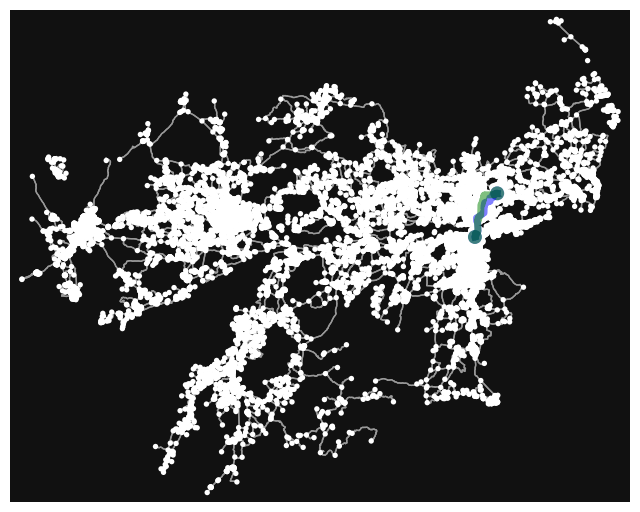


An error occurred: 'tuple' object has no attribute 'add_child'


In [23]:
import osmnx as ox
import networkx as nx
import pandas as pd
import requests
import time
import folium

# --- 1. Reload Graph and Fuel Model (to make this cell self-contained) ---
place_name = "Vellore, Tamil Nadu, India"
print(f"--- Loading street network and applying fuel model for {place_name} ---")

try:
    # This entire block re-creates the graph 'G' with the fuel_cost attribute.
    # It's included to ensure this cell can run independently.
    G = ox.graph_from_place(place_name, network_type='drive', retain_all=False)

    # Manually fetch elevation data in batches
    nodes_df = ox.graph_to_gdfs(G, edges=False)[['y', 'x']]
    elevations = {}
    batch_size = 100
    for i in range(0, len(nodes_df), batch_size):
        batch_nodes = nodes_df.iloc[i:i+batch_size]
        locations_str = "|".join([f"{lat},{lon}" for lat, lon in batch_nodes[['y', 'x']].values])
        url = f"https://api.opentopodata.org/v1/mapzen?locations={locations_str}"
        response = requests.get(url)
        if response.status_code == 200:
            results = response.json()['results']
            for j, data in enumerate(results):
                if data and 'elevation' in data:
                    elevations[batch_nodes.index[j]] = data['elevation']
        time.sleep(0.5)

    nx.set_node_attributes(G, values=elevations, name='elevation')
    nodes_to_remove = [node for node, data in G.nodes(data=True) if 'elevation' not in data]
    G.remove_nodes_from(nodes_to_remove)
    G = ox.add_edge_grades(G)

    # Apply fuel model
    w_dist = 1.0
    w_uphill = 15.0
    for u, v, data in G.edges(data=True):
        grade = data.get('grade', 0)
        length = data.get('length', 0)
        data['fuel_cost'] = (w_dist * length) + (w_uphill * length * max(0, grade))

    print("Graph prepared successfully.")

    # --- 2. Define Origin and Destination ---
    # We'll pick two well-known points in Vellore.
    # For example, from Vellore Institute of Technology (VIT) to CMC Hospital.
    origin_point = (12.9717, 79.1594)  # Approximate coordinates for VIT Vellore
    destination_point = (12.9269, 79.1351) # Approximate coordinates for CMC Hospital

    # Find the nearest graph nodes to our specified points
    origin_node = ox.nearest_nodes(G, Y=origin_point[0], X=origin_point[1])
    destination_node = ox.nearest_nodes(G, Y=destination_point[0], X=destination_point[1])

    # --- 3. Calculate the Routes ---
    print("\n--- Calculating routes ---")

    # Calculate the shortest route using 'length' as the weight
    shortest_route = nx.shortest_path(G, source=origin_node, target=destination_node, weight='length')
    shortest_route_length = nx.shortest_path_length(G, source=origin_node, target=destination_node, weight='length')

    # Calculate the most fuel-efficient route using 'fuel_cost' as the weight
    fuel_efficient_route = nx.shortest_path(G, source=origin_node, target=destination_node, weight='fuel_cost')
    fuel_efficient_route_length = nx.shortest_path_length(G, source=origin_node, target=destination_node, weight='length')

    # This helper function iterates through the edges in a route and sums a specific attribute.
    def calculate_route_cost(graph, route, attribute):
        cost = 0
        for u, v in zip(route[:-1], route[1:]):
            edge_data = graph.get_edge_data(u, v, 0)
            cost += edge_data.get(attribute, 0)
        return cost

    # Calculate the total fuel cost for both routes to compare
    shortest_route_fuel_cost = calculate_route_cost(G, shortest_route, 'fuel_cost')
    fuel_efficient_route_fuel_cost = calculate_route_cost(G, fuel_efficient_route, 'fuel_cost')

    # --- 4. Print Results Summary ---
    print("\n--- Route Comparison ---")
    print(f"Shortest Route: {shortest_route_length/1000:.2f} km")
    print(f"  - Estimated Fuel Cost: {shortest_route_fuel_cost:.2f} units")
    print(f"Fuel-Efficient Route: {fuel_efficient_route_length/1000:.2f} km")
    print(f"  - Estimated Fuel Cost: {fuel_efficient_route_fuel_cost:.2f} units")

    if shortest_route_fuel_cost > 0:
        fuel_savings = 100 * (1 - (fuel_efficient_route_fuel_cost / shortest_route_fuel_cost))
        print(f"\nFuel Savings with efficient route: {fuel_savings:.2f}%")
    else:
        print("\nCould not calculate fuel savings.")

    # --- 5. Visualize the Routes on an Interactive Map ---
    # FIX: The modern way to plot multiple routes is to pass them as a list.
    routes_to_plot = [shortest_route, fuel_efficient_route]
    route_colors = ['blue', 'green']

    # Plot both routes on the same map
    route_map = ox.plot_graph_routes(G, routes_to_plot, route_colors=route_colors, route_linewidths=5)

    # Add markers for origin and destination
    folium.Marker(location=origin_point, popup='Origin (VIT)', icon=folium.Icon(color='blue')).add_to(route_map)
    folium.Marker(location=destination_point, popup='Destination (CMC)', icon=folium.Icon(color='red')).add_to(route_map)

    # Display the map
    display(route_map)

except Exception as e:
    print(f"\nAn error occurred: {e}")

